In [6]:
import ibis
import json
import csv
import pandas as pd
import unidecode
from toolz import valmap, merge_with
from datetime import datetime
import matplotlib.pyplot as plt
%matplotlib inline  

In [7]:
start_date = datetime(2016,10,3)
end_date = datetime(2016,10,14)

PREFIX_PATH = '/Users/lexa/personal/xinga-muito/data/storage/test/raw_tweets/'
DBS_NAMES = ['nubank', 
             'itau', 
             'bradesco',
             'digio',
             'original', 
             'brasil', 
             'santander', 
#              'caixa',
            ]
USER_IDS = {'nubank': '2319390320',
            'itau': '179398386',
            'bradesco': '79184083',
            'digio': '747872859230441473',
            'original': '1615322238',
            'brasil': '83723557', 
#             'caixa': 
            'santander': '48700857'
           }

with open('bad_words.txt', 'rb') as f:
    reader = csv.reader(f)
    BAD_WORDS = map(lambda x: x[0], filter(lambda x: x!=[], list(reader)))

In [8]:
def filter_db(df, lang='pt', lower_date=start_date, upper_date=end_date):
    return df[(df.blob
                .apply(lambda x: json.loads(x))
                .apply(lambda x: x['lang'] == lang)) 
              & (df.tweet_create_at >= lower_date)
              & (df.tweet_create_at <= upper_date)]

def treat_tweets(text):
    return unidecode.unidecode(text.lower()).split()

def is_bad_word(text):
    return True if filter(lambda w: w in BAD_WORDS, text) else False

def df_treat_tweets(df):
    df['tweet_text_treated'] = df.tweet_text.apply(lambda x: treat_tweets(x))
    df['contains_bad_word'] = df.tweet_text_treated.apply(lambda x: is_bad_word(x))
    df['count_words'] = df.tweet_text_treated.apply(lambda x: len(x))
    return df

def summary(df):
    return pd.Series({'n_tweets': df.shape[0],
             'n_tweets_bad': df.contains_bad_word.sum(),
             'prop_tweets_bad': float(df.contains_bad_word.sum()*100)/df.shape[0],
#              'mean_followers': df.user_followers_count.mean(),
#              'mean_followers_bad': df[df.contains_bad_word].user_followers_count.mean(),
             'median_followers': df.user_followers_count.median(),
             'median_followers_bad': df[df.contains_bad_word].user_followers_count.median(),
#              'mean_words_tweets': df.count_words.mean(),
#              'mean_words_tweets_bad': df[df.contains_bad_word].count_words.mean(),
             'median_words_tweets': df.count_words.median(),
             'median_words_tweets_bad': df[df.contains_bad_word].count_words.median()
            })

In [9]:
all_dbs = dict(zip(DBS_NAMES, map(lambda db: ibis.sqlite
                                             .connect('{}{}.db'.format(PREFIX_PATH, db))
                                             .table('{}tweets'.format(db))
                                             .execute(), DBS_NAMES)))
filtered_dbs = valmap(lambda db: filter_db(db), all_dbs)
filtered_dbs_ids = merge_with(lambda x: {'id': x[0], 'full_db': x[1]}, 
                              USER_IDS, filtered_dbs)
split_dbs = valmap(lambda x: 
                   {'bank': x['full_db'][x['full_db'].user_id == x['id']],
                    'other': x['full_db'][x['full_db'].user_id != x['id']]}, filtered_dbs_ids)

In [10]:
for b in split_dbs:
    print b
    all_tweets = split_dbs[b]['bank'].shape[0] + split_dbs[b]['other'].shape[0]
    from_tweets = split_dbs[b]['bank'].shape[0]
    to_tweets = split_dbs[b]['other'].shape[0]
    print '   Total: %d' %all_tweets
    print '   Bank: %d (%.0f%%)' %(from_tweets, float(from_tweets*100)/all_tweets)
    print '   Other / Clients: %d (%.0f%%)' %(to_tweets, float(to_tweets*100)/all_tweets)
    print 

nubank
   Total: 3656
   Bank: 1035 (28%)
   Other / Clients: 2621 (72%)

brasil
   Total: 2756
   Bank: 697 (25%)
   Other / Clients: 2059 (75%)

santander
   Total: 2912
   Bank: 959 (33%)
   Other / Clients: 1953 (67%)

itau
   Total: 6954
   Bank: 1042 (15%)
   Other / Clients: 5912 (85%)

digio
   Total: 512
   Bank: 164 (32%)
   Other / Clients: 348 (68%)

original
   Total: 293
   Bank: 99 (34%)
   Other / Clients: 194 (66%)

bradesco
   Total: 9658
   Bank: 2199 (23%)
   Other / Clients: 7459 (77%)



In [11]:
treat_text_others = valmap(lambda dfs: df_treat_tweets(dfs['other']), split_dbs)
summaries = valmap(lambda df: summary(df).apply(lambda x: round(x, 2)), treat_text_others)

df_summaries = pd.DataFrame()
for s in summaries:
    df_summaries = pd.concat([df_summaries, pd.DataFrame(summaries[s], columns=[s])], axis=1)

/Applications/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:9: RuntimeWarning: Surrogate character u'\ud83d' will be ignored. You might be using a narrow Python build.
/Applications/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:9: RuntimeWarning: Surrogate character u'\udc4d' will be ignored. You might be using a narrow Python build.
/Applications/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:9: RuntimeWarning: Surrogate character u'\ud83c' will be ignored. You might be using a narrow Python build.
/Applications/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:9: RuntimeWarning: Surrogate character u'\udffd' will be ignored. You might be using a narrow Python build.
/Applications/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:9: RuntimeWarning: Surrogate character u'\udc4e' will be ignored. You might be using a narrow Python build.
/Applications/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:9: RuntimeWarning: Sur

In [12]:
df_summaries

,nubank,brasil,santander,itau,digio,original,bradesco
median_followers,308.00,360.00,388.00,425.50,379.00,310.00,381.00
median_followers_bad,434.00,462.00,412.00,414.00,450.00,1635.00,522.00
median_words_tweets,13.00,16.00,16.00,16.00,13.00,16.00,17.00
median_words_tweets_bad,18.00,17.00,18.00,16.00,21.00,14.50,11.00
n_tweets,2621.00,2059.00,1953.00,5912.00,348.00,194.00,7459.00
n_tweets_bad,35.00,69.00,46.00,141.00,5.00,2.00,318.00
prop_tweets_bad,1.34,3.35,2.36,2.38,1.44,1.03,4.26


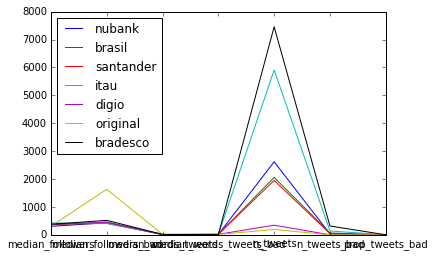

In [13]:
df_summaries.plot()